# BASICS 02 - HOTS algorithm (Lagorce et al. 2017)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tonic, torch, os
from hots.network import network
from hots.utils import get_loader, make_histogram_classification, HOTS_Dataset

print(f'Tonic version installed -> {tonic.__version__}')

print(f'Number of GPU devices available: {torch.cuda.device_count()}')
for N_gpu in range(torch.cuda.device_count()):
    print(f'GPU {N_gpu+1} named {torch.cuda.get_device_name(N_gpu)}')

if torch.cuda.device_count() == 0:
    device = 'cpu'
else:
    device = 'cuda'

/gs/home/grimaldiav/.conda/envs/hotsline/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Tonic version installed -> 1.4.2
Number of GPU devices available: 0


## Loading of the dataset for the clustering phase

In [3]:
transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=transform)
trainloader = get_loader(trainset, shuffle=True)
testloader = get_loader(testset, shuffle=True)
num_sample_train = len(trainloader)
num_sample_test = len(testloader)
print(f'number of samples in the training set: {len(trainloader)}')

number of samples in the training set: 48


## Initialization of the network

In [4]:
name = 'homeohots'
homeo = True
timestr = '2022-06-06'
dataset_name = 'poker'

Rz = [2, 4]
N_neuronz = [8, 16]
tauz = [1e3, 4e3]

hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo, device = device)

../Records/networks/2022-06-06_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4].pkl


## Unsupervised clustering

In [5]:
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
path = '../Records/networks/'+hots.name+'.pkl'
if not os.path.exists(path):
    hots.clustering(trainloader, trainset.ordering, record = True, device = device)

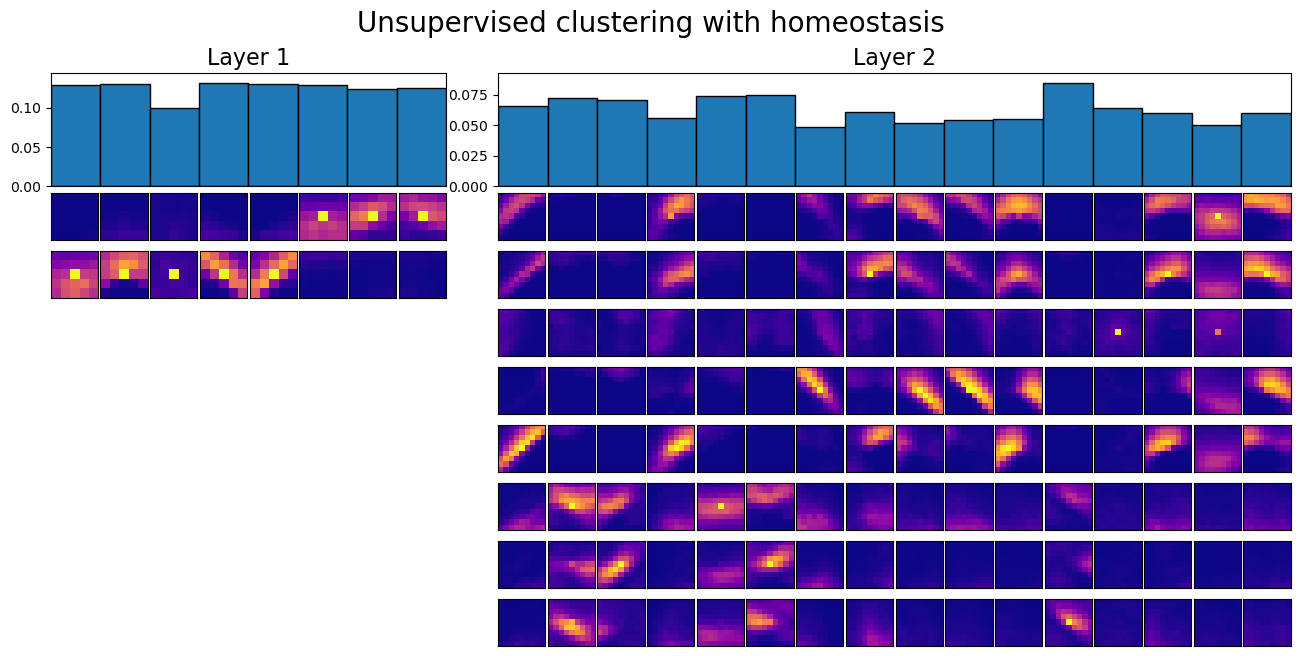

In [6]:
hots.plotlayers();

In [7]:
hots.plotlearning();

FileNotFoundError: [Errno 2] No such file or directory: '../Records/networks/2022-06-06_poker_homeohots_True_[8, 16]_[1000.0, 4000.0]_[2, 4]_recorded_parameters.pkl'

## Coding of the training set

In [ ]:
hots.coding(trainloader, trainset.ordering, trainset.classes, training=True, device=device)

## Coding of the testing set

In [ ]:
hots.coding(testloader, testset.ordering, testset.classes, training=False, device=device)

## Classification with histogram (post-hoc)

In [ ]:
jitter = (None, None)

train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, trainset.classes, dtype=trainset.dtype, transform=transform)
testset_output = HOTS_Dataset(test_path, trainset.sensor_size, testset.classes, dtype=trainset.dtype, transform=transform)

In [ ]:
score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1], device=device)
print(f' Accuracy: {score*100}%')